In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
import numpy as np
from IPython.display import Image
from typing import Callable
from itertools import product
from pprint import pprint
import pickle
from itertools import product

# Mutations experiment: Generate joint distribution and ground truth

We will use a bayesian network to generate the joint distribution.
The ground truth encoder will be coded manually.
Two pickle files will be saved with the results.

## Joint

In [3]:
net = BayesianNetwork()
net.add_nodes_from(['X1', 'X2', 'X3', 'X4', 'Y', 'S'])
net.add_edges_from(
    [('X1', 'Y'),
     ('X2', 'Y'),
     ('X3', 'Y'),
     ('S', 'X3'),
     ('S', 'X4'),
     ('S', 'Y')])

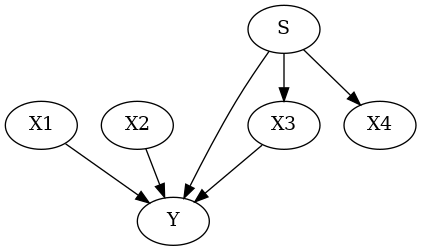

In [4]:
graph = net.to_graphviz()
graph.draw('mutations_graph.png', prog='dot')
Image('mutations_graph.png')

In [5]:
# Bernoulli probabilities for the exogenous variables
#bxi = 0.5
bxi = 0.3
by = 0.1
bs = 0.5

### Define CPD tables

In [6]:
X1cpd_table = np.array([ [1 - bxi, bxi] ]).T
X2cpd_table = np.array([ [1 - bxi, bxi] ]).T
X3cpd_table = np.array([
    [1 - bxi, bxi],
    [bxi, 1 - bxi] 
])
X4cpd_table = np.array([
    [1 - bxi, bxi],
    [bxi, 1 - bxi] 
])
Scpd_table = np.array([ [1 - bs, bs] ]).T

In [7]:
Ycpd_Seq0 = np.array([
    [1-by, 1-by, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [by, by, 1-by, 1-by, 1-by, 1-by, 0.0, 0.0],
    [0.0, 0.0, by, by, by, by, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1-by],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1-by, by],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, by, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
])
Ycpd_Seq1 = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1-by, 1-by, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [by, by, 1-by, 1-by, 1-by, 1-by, 0.0, 0.0],
    [0.0, 0.0, by, by, by, by, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1-by],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1-by, by],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, by, 0.0]
])

# Ycpd will just be concatenation of these:
Ycpd_table = np.concatenate((Ycpd_Seq0, Ycpd_Seq1), axis=1)
print(Ycpd_table)

[[0.9 0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.1 0.9 0.9 0.9 0.9 0.  0.  0.9 0.9 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.9 0.9 0.9 0.9 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.  0.  0.1 0.1 0.1 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.9]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.9 0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]]


In [8]:
X1cpd = TabularCPD('X1',variable_card=2, values=X1cpd_table)
X2cpd = TabularCPD('X2',variable_card=2, values=X2cpd_table)
X3cpd = TabularCPD('X3',variable_card=2, values=X3cpd_table, evidence=['S'], evidence_card=[2])
X4cpd = TabularCPD('X4',variable_card=2, values=X4cpd_table, evidence=['S'], evidence_card=[2])
Ycpd = TabularCPD('Y',variable_card=7, values=Ycpd_table, evidence=['S','X1','X2','X3'], evidence_card=[2,2,2,2])
Scpd = TabularCPD('S',variable_card=2, values=Scpd_table)

In [9]:
print(Scpd)
print(X1cpd)
print(X3cpd)
print(Ycpd)

+------+-----+
| S(0) | 0.5 |
+------+-----+
| S(1) | 0.5 |
+------+-----+
+-------+-----+
| X1(0) | 0.7 |
+-------+-----+
| X1(1) | 0.3 |
+-------+-----+
+-------+------+------+
| S     | S(0) | S(1) |
+-------+------+------+
| X3(0) | 0.7  | 0.3  |
+-------+------+------+
| X3(1) | 0.3  | 0.7  |
+-------+------+------+
+------+-------+-------+-------+-----+-------+-------+-------+-------+
| S    | S(0)  | S(0)  | S(0)  | ... | S(1)  | S(1)  | S(1)  | S(1)  |
+------+-------+-------+-------+-----+-------+-------+-------+-------+
| X1   | X1(0) | X1(0) | X1(0) | ... | X1(1) | X1(1) | X1(1) | X1(1) |
+------+-------+-------+-------+-----+-------+-------+-------+-------+
| X2   | X2(0) | X2(0) | X2(1) | ... | X2(0) | X2(0) | X2(1) | X2(1) |
+------+-------+-------+-------+-----+-------+-------+-------+-------+
| X3   | X3(0) | X3(1) | X3(0) | ... | X3(0) | X3(1) | X3(0) | X3(1) |
+------+-------+-------+-------+-----+-------+-------+-------+-------+
| Y(0) | 0.9   | 0.9   | 0.0   | ... |

### Use CPDs and network to generate joint

In [10]:
net.add_cpds(X1cpd, X2cpd, X3cpd, X4cpd, Ycpd, Scpd)
#net.get_state_probability({"Y": 3})

In [11]:
vals: dict[str, list[int]] = {}
node: str
for node in net.nodes:
    card: int = net.get_cardinality(node)
    vals[node] = list(range(card))

In [12]:
# What we need to compute the joint the probabilities for all combinations of values of all variables:
all_vals: tuple[list[int]] = tuple(vals[node] for node in net.nodes)
joint_vals: list[tuple[int]] = list(product(*all_vals))

In [13]:
nodes: tuple[str] = tuple(net.nodes)
print(nodes)
state: tuple[int]
probs: dict[tuple[int], float] = {}
for state in joint_vals:
    state_dict: dict[str, int] = {node: state for node, state in zip(nodes, state)}
    prob: float = net.get_state_probability(state_dict)
    probs[state] = prob
#pprint(probs)

('X1', 'X2', 'X3', 'X4', 'Y', 'S')


In [14]:
joint_table: np.ndarray = np.zeros(tuple(net.get_cardinality(node) for node in net.nodes))

for (i1, i2, i3, i4, j, y), prob in probs.items():
    joint_table[i1, i2, i3, i4, j, y] = prob

In [15]:
with open(f"mutations_joint_distribution_table_{bxi}-{by}-{bs}.pkl", 'wb') as handle:
    pickle.dump(joint_table, handle)

## Max control theoretical solution

In [16]:
NTs = (4,)
NXs = (2, 2, 2, 2)  # X1 through X4 are binary

SOL_Q: np.ndarray = np.zeros(NTs + NXs)

In [17]:
for x4 in range(NXs[3]):
    SOL_Q[0,:,:,:,x4] = np.array([
        [[1, 1],
        [0, 0]],
        
        [[0, 0],
        [0, 0]]
    ])
    
    SOL_Q[1,:,:,:,x4] = np.array([
        [[0, 0],
        [1, 1]],
        
        [[1, 1],
        [0, 0]]
    ])
    
    SOL_Q[2,:,:,:,x4] = np.array([
        [[0, 0],
        [0, 0]],
        
        [[0, 0],
        [1, 0]]
    ])
    
    SOL_Q[3,:,:,:,x4] = np.array([
        [[0, 0],
        [0, 0]],
        
        [[0, 0],
        [0, 1]]
    ])

Confirm that all conditionals p(t|x1,...,x4) are normalized:

In [18]:
ranges =  tuple(list(range(NXs[n])) for n in range(len(NXs)))
#print(list(product(*ranges)))
for x1, x2, x3, x4 in product(*ranges): 
    assert np.sum(SOL_Q[:,x1,x2,x3,x4]) == 1.0

In [19]:
#print(SOL_Q.shape)
with open("mutations_sol_q.pkl", 'wb') as handle:
    pickle.dump(SOL_Q, handle)